In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import pickle 

import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from PIL import Image
import json
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [38]:
data = pd.read_csv("retina_insights.csv")
data.drop(columns=["Unnamed: 0"], inplace= True)
data.columns
data.head()

,disc_diameter,cup_diameter,disc_area,cup_area
0,0.009135,0.012185,0.000066,0.000117
1,0.014285,0.007560,0.000160,0.000045
2,0.007950,0.004225,0.000050,0.000014
3,0.004290,0.011795,0.000014,0.000109
4,0.004795,0.007955,0.000018,0.000050


In [39]:
print(data.shape)
data.isnull().sum()

(325, 4)


disc_diameter    0
cup_diameter     0
disc_area        0
cup_area         0
dtype: int64

Text(0, 0.5, 'Cup area')

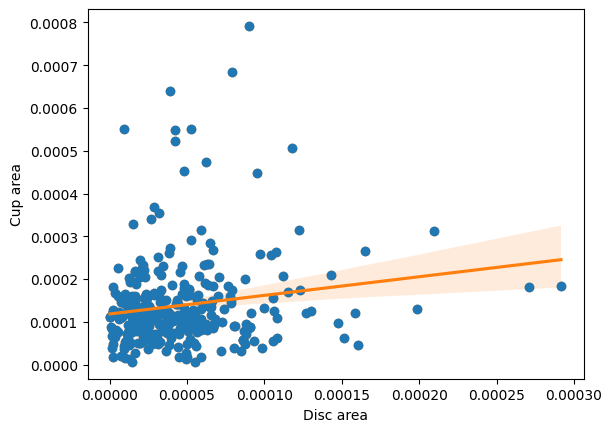

In [40]:
plt.plot(data["disc_area"], data["cup_area"], linestyle="",marker="o")
sns.regplot(x=data["disc_area"],y=data["cup_area"])
plt.xlabel("Disc area")
plt.ylabel("Cup area")

Text(0, 0.5, 'Cup diameter')

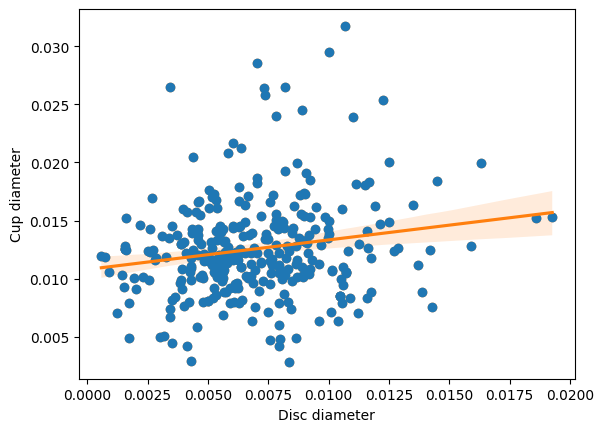

In [41]:
plt.plot(data["disc_diameter"], data["cup_diameter"], linestyle="",marker="o")
sns.regplot(x=data["disc_diameter"],y=data["cup_diameter"])
plt.xlabel("Disc diameter")
plt.ylabel("Cup diameter")
# sns.scatterplot(data=data["cup_diameter"])

<Axes: >

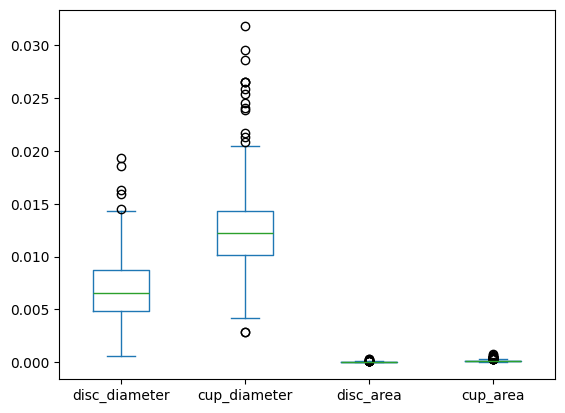

In [42]:
data.plot(kind="box")

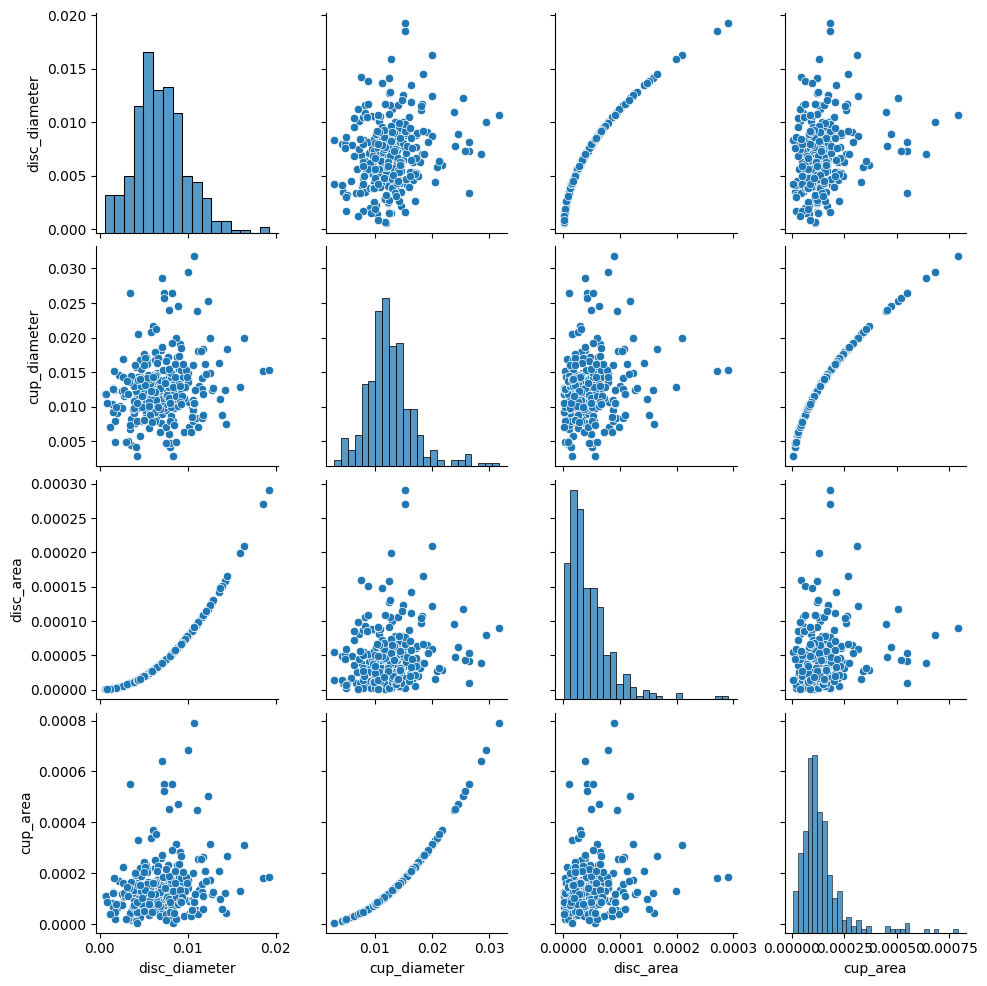

In [43]:
sns.pairplot(data=data)

In [6]:
data = pd.read_csv("retina_insights.csv")
def distance_line(x,y):
    m, c = np.polyfit(x, y, 1)
    # print(m)
    # print(c)
    
    distances = []
    for xi, yi in zip(x, y):
        distance = abs(m * xi - yi + c) / np.sqrt(m**2 + 1)
        distances.append(distance)
    # print(distances)
    distances = np.mean(distances)
    # print(distances)
    c_above = c + distances * np.sqrt(1 + m**2)
    c_below = c - distances * np.sqrt(1 + m**2)
    return m, c_below, c, c_above
values = distance_line(data["disc_diameter"], data["cup_diameter"])
pickle.dump(values[0],open("slope.pkl","wb"))
pickle.dump(values[2],open("intercept.pkl","wb"))

In [12]:
def point_position_parallel(m, c, point):
    x, y = point
    y_on_line = m * x + c

    if y > y_on_line:
        return "No Hypertensive Retinopathy"
    elif y < y_on_line:
        return "Hypertensive Retinopathy"
    else:
        return "Borderline/Unclear"


In [13]:
answers = ["having hypertension retinopathy", "might be having hypertension retinopathy", "might not be having hypertension retinopathy", "not having hypertension retinopathy"]
ref = [0,0,0,0]

In [14]:
class RetinaFundusDataset(Dataset):
    def __init__(self, images_dir, annotations_dir=None, transform=None):
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg') or f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, self.image_files[idx])

        # Check if annotations are available
        if self.annotations_dir:
            annotation_name = os.path.join(self.annotations_dir, self.image_files[idx].replace('.jpg', '.json').replace('.png', '.json'))
            # Load annotations (bounding boxes)
            if os.path.exists(annotation_name):
                with open(annotation_name, 'r') as f:
                    annotations = json.load(f)

                # Extract bounding boxes for optic disc and optic disc diameter
                disc_box = annotations['optic_disc']
                cup_box = annotations['optic_cup']

                # Extract height and width of the bounding boxes
                disc_height = disc_box['height']
                disc_width = disc_box['width']
                cup_height = cup_box['height']
                cup_width = cup_box['width']

                # Targets: height and width of optic disc and optic disc diameter
                target = [disc_height, disc_width, cup_height, cup_width]
            else:
                target = torch.zeros(4)  # Default to zero if annotation file is missing
        else:
            # No annotations in test set
            target = torch.zeros(4)  # Dummy target for test set, no annotations required

        # Load image
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(target, dtype=torch.float32)
class RetinaModel(nn.Module):
    def __init__(self):
        super(RetinaModel, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 4)  # 4 outputs for height/width of optic disc and cup
    
    def forward(self, x):
        return self.resnet(x)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [15]:
input_images_dir = 'testing_images'  # Replace with the path to your folder

# Create dataset and dataloader for input images
input_dataset = RetinaFundusDataset(input_images_dir, transform=transform)
input_loader = DataLoader(input_dataset, batch_size=1, shuffle=False)

# Load the trained model
model = RetinaModel()  # Ensure this is your trained model class
model.load_state_dict(torch.load('retina_model.pth'))  # Load the saved model
model.eval()  # Set the model to evaluation mode


#function to check if the given data in an outlier

# Evaluate the model on input images
i=1
with torch.no_grad():
    for inputs, file_names in input_loader:
        outputs = model(inputs)
        
        # Extract predicted bounding boxes (height, width)
        disc_height, disc_width, cup_height, cup_width = abs(outputs[0])

        # Calculate the area of optic disc and optic disc diameter
        disc_area = disc_height * disc_width
        cup_area = cup_height * cup_width

        # Display the results
        # print(f"Image: {file_names[0]}")
        print(f"Image {i}:")
        i+=1
        # print(f"Optic Disc - Height: {disc_height:.2f}, Width: {disc_width:.2f}, Area: {disc_area:.2f}")
        # print(f"Optic Cup - Height: {cup_height:.2f}, Width: {cup_width:.2f}, Area: {cup_area:.2f}")
        
        #**DELETE**
        #calculating the diameters and the areas
        disc_diameter = (disc_height+disc_width)/2
        cup_diameter = (cup_height+cup_width)/2
        DiscArea = np.pi*(disc_diameter/2)**2
        CupArea = np.pi*(cup_diameter/2)**2
        
        # classify=[DiscDiameterBound<=disc_diameter,CupDiameterBound<=cup_diameter,DiscAreaBound<=DiscArea,CupAreaBound<=CupArea]
        # print(classify)
        # print(disc_diameter,cup_diameter, DiscArea, CupArea)
        #area
        values = distance_line(data["disc_area"], data["cup_area"])
        result1 = point_position_parallel(values[0], values[1], values[2], values[3], (DiscArea,CupArea))
        
        #diameter
        values = distance_line(data["disc_diameter"], data["cup_diameter"])
        result2 = point_position_parallel(values[0], values[1], values[2], values[3], (disc_diameter,cup_diameter))
        if result1==result2:
            print(answers[result2])
        else:
            print(answers[2])
        

C:\python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14912\4234954942.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models fo

RuntimeError: Error(s) in loading state_dict for RetinaModel:
	Missing key(s) in state_dict: "resnet.conv1.weight", "resnet.bn1.weight", "resnet.bn1.bias", "resnet.bn1.running_mean", "resnet.bn1.running_var", "resnet.layer1.0.conv1.weight", "resnet.layer1.0.bn1.weight", "resnet.layer1.0.bn1.bias", "resnet.layer1.0.bn1.running_mean", "resnet.layer1.0.bn1.running_var", "resnet.layer1.0.conv2.weight", "resnet.layer1.0.bn2.weight", "resnet.layer1.0.bn2.bias", "resnet.layer1.0.bn2.running_mean", "resnet.layer1.0.bn2.running_var", "resnet.layer1.1.conv1.weight", "resnet.layer1.1.bn1.weight", "resnet.layer1.1.bn1.bias", "resnet.layer1.1.bn1.running_mean", "resnet.layer1.1.bn1.running_var", "resnet.layer1.1.conv2.weight", "resnet.layer1.1.bn2.weight", "resnet.layer1.1.bn2.bias", "resnet.layer1.1.bn2.running_mean", "resnet.layer1.1.bn2.running_var", "resnet.layer2.0.conv1.weight", "resnet.layer2.0.bn1.weight", "resnet.layer2.0.bn1.bias", "resnet.layer2.0.bn1.running_mean", "resnet.layer2.0.bn1.running_var", "resnet.layer2.0.conv2.weight", "resnet.layer2.0.bn2.weight", "resnet.layer2.0.bn2.bias", "resnet.layer2.0.bn2.running_mean", "resnet.layer2.0.bn2.running_var", "resnet.layer2.0.downsample.0.weight", "resnet.layer2.0.downsample.1.weight", "resnet.layer2.0.downsample.1.bias", "resnet.layer2.0.downsample.1.running_mean", "resnet.layer2.0.downsample.1.running_var", "resnet.layer2.1.conv1.weight", "resnet.layer2.1.bn1.weight", "resnet.layer2.1.bn1.bias", "resnet.layer2.1.bn1.running_mean", "resnet.layer2.1.bn1.running_var", "resnet.layer2.1.conv2.weight", "resnet.layer2.1.bn2.weight", "resnet.layer2.1.bn2.bias", "resnet.layer2.1.bn2.running_mean", "resnet.layer2.1.bn2.running_var", "resnet.layer3.0.conv1.weight", "resnet.layer3.0.bn1.weight", "resnet.layer3.0.bn1.bias", "resnet.layer3.0.bn1.running_mean", "resnet.layer3.0.bn1.running_var", "resnet.layer3.0.conv2.weight", "resnet.layer3.0.bn2.weight", "resnet.layer3.0.bn2.bias", "resnet.layer3.0.bn2.running_mean", "resnet.layer3.0.bn2.running_var", "resnet.layer3.0.downsample.0.weight", "resnet.layer3.0.downsample.1.weight", "resnet.layer3.0.downsample.1.bias", "resnet.layer3.0.downsample.1.running_mean", "resnet.layer3.0.downsample.1.running_var", "resnet.layer3.1.conv1.weight", "resnet.layer3.1.bn1.weight", "resnet.layer3.1.bn1.bias", "resnet.layer3.1.bn1.running_mean", "resnet.layer3.1.bn1.running_var", "resnet.layer3.1.conv2.weight", "resnet.layer3.1.bn2.weight", "resnet.layer3.1.bn2.bias", "resnet.layer3.1.bn2.running_mean", "resnet.layer3.1.bn2.running_var", "resnet.layer4.0.conv1.weight", "resnet.layer4.0.bn1.weight", "resnet.layer4.0.bn1.bias", "resnet.layer4.0.bn1.running_mean", "resnet.layer4.0.bn1.running_var", "resnet.layer4.0.conv2.weight", "resnet.layer4.0.bn2.weight", "resnet.layer4.0.bn2.bias", "resnet.layer4.0.bn2.running_mean", "resnet.layer4.0.bn2.running_var", "resnet.layer4.0.downsample.0.weight", "resnet.layer4.0.downsample.1.weight", "resnet.layer4.0.downsample.1.bias", "resnet.layer4.0.downsample.1.running_mean", "resnet.layer4.0.downsample.1.running_var", "resnet.layer4.1.conv1.weight", "resnet.layer4.1.bn1.weight", "resnet.layer4.1.bn1.bias", "resnet.layer4.1.bn1.running_mean", "resnet.layer4.1.bn1.running_var", "resnet.layer4.1.conv2.weight", "resnet.layer4.1.bn2.weight", "resnet.layer4.1.bn2.bias", "resnet.layer4.1.bn2.running_mean", "resnet.layer4.1.bn2.running_var", "resnet.fc.weight", "resnet.fc.bias". 
	Unexpected key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "bn1.num_batches_tracked", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.bn1.num_batches_tracked", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.0.bn2.num_batches_tracked", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.bn1.num_batches_tracked", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer1.1.bn2.num_batches_tracked", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.bn1.num_batches_tracked", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.bn2.num_batches_tracked", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.0.downsample.1.num_batches_tracked", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.bn1.num_batches_tracked", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer2.1.bn2.num_batches_tracked", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.bn1.num_batches_tracked", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.bn2.num_batches_tracked", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.0.downsample.1.num_batches_tracked", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.bn1.num_batches_tracked", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer3.1.bn2.num_batches_tracked", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.bn1.num_batches_tracked", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.bn2.num_batches_tracked", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.0.downsample.1.num_batches_tracked", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.bn1.num_batches_tracked", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "layer4.1.bn2.num_batches_tracked", "fc.weight", "fc.bias". 

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from PIL import Image
import os
import json
import numpy as np

# Define your dataset class
class RetinaFundusDataset(Dataset):
    def __init__(self, images_dir, annotations_dir=None, transform=None):
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg') or f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, self.image_files[idx])

        # Check if annotations are available
        if self.annotations_dir:
            annotation_name = os.path.join(self.annotations_dir, self.image_files[idx].replace('.jpg', '.json').replace('.png', '.json'))
            # Load annotations (bounding boxes)
            if os.path.exists(annotation_name):
                with open(annotation_name, 'r') as f:
                    annotations = json.load(f)

                # Extract bounding boxes for optic disc and optic cup
                disc_box = annotations['optic_disc']
                cup_box = annotations['optic_cup']

                # Extract height and width of the bounding boxes
                disc_height = disc_box['height']
                disc_width = disc_box['width']
                cup_height = cup_box['height']
                cup_width = cup_box['width']

                # Targets: height and width of optic disc and optic cup
                target = [disc_height, disc_width, cup_height, cup_width]
            else:
                target = [0, 0, 0, 0]  # Default to zero if annotation file is missing
        else:
            # No annotations in test set
            target = [0, 0, 0, 0]  # Dummy target for test set, no annotations required

        # Load image
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(target, dtype=torch.float32)

# Define your model
class RetinaModel(nn.Module):
    def __init__(self):
        super(RetinaModel, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 4)  # 4 outputs for height/width of optic disc and cup

    def forward(self, x):
        return self.resnet(x)

# Create the transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define paths (use your actual paths)
train_images_dir = r"C:\Users\ASUS\Downloads\hyper\Autism\data\train"  # Replace with your actual path
train_annotations_dir = r"C:\Users\ASUS\Downloads\hyper\Autism\annotations"  # Replace with your actual path

# Create dataset and dataloaders
train_dataset = RetinaFundusDataset(train_images_dir, annotations_dir=train_annotations_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize model, loss function, and optimizer
model = RetinaModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Track and store training losses for visualization
training_losses = []

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    epoch_loss = running_loss/len(train_loader)
    training_losses.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}')

# Plot training loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), training_losses, marker='o', linestyle='-', color='b')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.grid(True)
plt.savefig('training_loss.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Load your data - this assumes you've already created and saved the CSV file
data = pd.read_csv("retina_insights.csv")

# Check if there's an unnamed column to drop
if 'Unnamed: 0' in data.columns:
    data.drop(columns=["Unnamed: 0"], inplace=True)

# Define your functions
def distance_line(x, y):
    m, c = np.polyfit(x, y, 1)
    distances = []
    for xi, yi in zip(x, y):
        distance = abs(m * xi - yi + c) / np.sqrt(m**2 + 1)
        distances.append(distance)
    distances = np.mean(distances)
    c_above = c + distances * np.sqrt(1 + m**2)
    c_below = c - distances * np.sqrt(1 + m**2)
    return m, c_below, c, c_above

def point_position_parallel(m, c1, c2, c3, point):
    x, y = point
    intercepts = sorted([(c1, "Line 1"), (c2, "Line 2"), (c3, "Line 3")])
    bottom_line, middle_line, top_line = intercepts
    y_bottom = m * x + bottom_line[0]
    y_middle = m * x + middle_line[0]
    y_top = m * x + top_line[0]
    
    if y < y_bottom:
        return 3
    elif y > y_top:
        return 0
    elif y_bottom < y < y_middle:
        return 2
    elif y_middle < y < y_top:
        return 1
    else:
        return 1

# Create a function to compute the classification for each row
def get_classification_area(row):
    m, c_below, c, c_above = distance_line(data["disc_area"], data["cup_area"])
    return point_position_parallel(m, c_below, c, c_above, (row["disc_area"], row["cup_area"]))

def get_classification_diameter(row):
    m, c_below, c, c_above = distance_line(data["disc_diameter"], data["cup_diameter"])
    return point_position_parallel(m, c_below, c, c_above, (row["disc_diameter"], row["cup_diameter"]))

# Add classification columns
data['area_class'] = data.apply(get_classification_area, axis=1)
data['diameter_class'] = data.apply(get_classification_diameter, axis=1)

# Visualize the classification boundaries
plt.figure(figsize=(12, 10))

# Plot for disc area vs cup area with classification boundaries
plt.subplot(2, 1, 1)
scatter = plt.scatter(data["disc_area"], data["cup_area"], c=data['area_class'], 
                     cmap='viridis', alpha=0.7)

# Add regression line and boundaries
m, c_below, c, c_above = distance_line(data["disc_area"], data["cup_area"])
x_range = np.linspace(min(data["disc_area"]), max(data["disc_area"]), 100)
plt.plot(x_range, m * x_range + c, 'r-', label='Mean Regression')
plt.plot(x_range, m * x_range + c_below, 'g--', label='Lower Boundary')
plt.plot(x_range, m * x_range + c_above, 'b--', label='Upper Boundary')

plt.colorbar(scatter, label='Classification Group')
plt.xlabel('Disc Area')
plt.ylabel('Cup Area')
plt.title('Classification based on Disc Area vs Cup Area')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot for disc diameter vs cup diameter with classification boundaries
plt.subplot(2, 1, 2)
scatter = plt.scatter(data["disc_diameter"], data["cup_diameter"], c=data['diameter_class'], 
                     cmap='viridis', alpha=0.7)

# Add regression line and boundaries
m, c_below, c, c_above = distance_line(data["disc_diameter"], data["cup_diameter"])
x_range = np.linspace(min(data["disc_diameter"]), max(data["disc_diameter"]), 100)
plt.plot(x_range, m * x_range + c, 'r-', label='Mean Regression')
plt.plot(x_range, m * x_range + c_below, 'g--', label='Lower Boundary')
plt.plot(x_range, m * x_range + c_above, 'b--', label='Upper Boundary')

plt.colorbar(scatter, label='Classification Group')
plt.xlabel('Disc Diameter')
plt.ylabel('Cup Diameter')
plt.title('Classification based on Disc Diameter vs Cup Diameter')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('classification_boundaries.png', dpi=300, bbox_inches='tight')
plt.show()

# Additional exploratory plots
plt.figure(figsize=(18, 6))

# Plot disc area vs cup area
plt.subplot(1, 3, 1)
plt.plot(data["disc_area"], data["cup_area"], linestyle="", marker="o")
sns.regplot(x=data["disc_area"], y=data["cup_area"])
plt.xlabel("Disc area")
plt.ylabel("Cup area")
plt.title("Disc Area vs Cup Area")

# Plot disc diameter vs cup diameter
plt.subplot(1, 3, 2)
plt.plot(data["disc_diameter"], data["cup_diameter"], linestyle="", marker="o")
sns.regplot(x=data["disc_diameter"], y=data["cup_diameter"])
plt.xlabel("Disc diameter")
plt.ylabel("Cup diameter")
plt.title("Disc Diameter vs Cup Diameter")

# Box plot of measurements
plt.subplot(1, 3, 3)
data.boxplot()
plt.title("Distribution of Measurements")
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('exploratory_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import json
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd

# Define your dataset class again (if not already defined in the session)
class RetinaFundusDataset(Dataset):
    def __init__(self, images_dir, annotations_dir=None, transform=None):
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg') or f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, self.image_files[idx])

        # Check if annotations are available
        if self.annotations_dir:
            annotation_name = os.path.join(self.annotations_dir, self.image_files[idx].replace('.jpg', '.json').replace('.png', '.json'))
            # Load annotations (bounding boxes)
            if os.path.exists(annotation_name):
                with open(annotation_name, 'r') as f:
                    annotations = json.load(f)

                # Extract bounding boxes for optic disc and optic cup
                disc_box = annotations['optic_disc']
                cup_box = annotations['optic_cup']

                # Extract height and width of the bounding boxes
                disc_height = disc_box['height']
                disc_width = disc_box['width']
                cup_height = cup_box['height']
                cup_width = cup_box['width']

                # Targets: height and width of optic disc and optic cup
                target = [disc_height, disc_width, cup_height, cup_width]
            else:
                target = [0, 0, 0, 0]  # Default to zero if annotation file is missing
        else:
            # No annotations in test set
            target = [0, 0, 0, 0]  # Dummy target for test set, no annotations required

        # Load image
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(target, dtype=torch.float32)

# Define model class
class RetinaModel(nn.Module):
    def __init__(self):
        super(RetinaModel, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 4)  # 4 outputs for height/width of optic disc and cup

    def forward(self, x):
        return self.resnet(x)

# Create the transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define paths
test_images_dir = 'data/test'  # Replace with your actual path
test_annotations_dir = 'annotations'  # Replace with your actual path if you have test annotations

# Create test dataset and dataloader
test_dataset = RetinaFundusDataset(test_images_dir, annotations_dir=test_annotations_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Load the trained model (assuming you've saved it earlier)
model = RetinaModel()
try:
    model.load_state_dict(torch.load('retina_model.pth'))
    print("Model loaded successfully!")
except:
    print("Warning: Could not load saved model. Using an untrained model for visualization only.")

# Set model to evaluation mode
model.eval()

# Lists to store predictions and ground truth
pred_disc_height = []
pred_disc_width = []
pred_cup_height = []
pred_cup_width = []
actual_disc_height = []
actual_disc_width = []
actual_cup_height = []
actual_cup_width = []

# Function to create sample predictions for visualization if no model is available
def create_sample_predictions(num_samples=10):
    # Create random sample predictions with some correlation to actual values
    for i in range(num_samples):
        # Actual values (typical ranges)
        dh = np.random.uniform(0.4, 0.7)
        dw = np.random.uniform(0.4, 0.7)
        ch = np.random.uniform(0.2, 0.4)
        cw = np.random.uniform(0.2, 0.4)
        
        # Predicted values (with some error)
        pdh = dh + np.random.normal(0, 0.05)
        pdw = dw + np.random.normal(0, 0.05)
        pch = ch + np.random.normal(0, 0.05)
        pcw = cw + np.random.normal(0, 0.05)
        
        # Store values
        actual_disc_height.append(dh)
        actual_disc_width.append(dw)
        actual_cup_height.append(ch)
        actual_cup_width.append(cw)
        pred_disc_height.append(pdh)
        pred_disc_width.append(pdw)
        pred_cup_height.append(pch)
        pred_cup_width.append(pcw)

try:
    # Get predictions for each image
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(test_loader):
            outputs = model(inputs)
            
            # Get actual values
            actual_disc_height.append(targets[0][0].item())
            actual_disc_width.append(targets[0][1].item())
            actual_cup_height.append(targets[0][2].item())
            actual_cup_width.append(targets[0][3].item())
            
            # Get predicted values
            pred_disc_height.append(outputs[0][0].item())
            pred_disc_width.append(outputs[0][1].item())
            pred_cup_height.append(outputs[0][2].item())
            pred_cup_width.append(outputs[0][3].item())
            
            # Limit to 20 samples for visualization
            if i >= 19:
                break
except:
    print("Error processing images or no test data available. Creating sample predictions for visualization.")
    create_sample_predictions(20)

# Create visualization of predictions vs actual values
plt.figure(figsize=(16, 12))

# Disc Height
plt.subplot(2, 2, 1)
plt.scatter(actual_disc_height, pred_disc_height, alpha=0.7)
# Plot perfect prediction line
min_val = min(min(actual_disc_height), min(pred_disc_height))
max_val = max(max(actual_disc_height), max(pred_disc_height))
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.title('Optic Disc Height: Predicted vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True, alpha=0.3)

# Disc Width
plt.subplot(2, 2, 2)
plt.scatter(actual_disc_width, pred_disc_width, alpha=0.7)
# Plot perfect prediction line
min_val = min(min(actual_disc_width), min(pred_disc_width))
max_val = max(max(actual_disc_width), max(pred_disc_width))
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.title('Optic Disc Width: Predicted vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True, alpha=0.3)

# Cup Height
plt.subplot(2, 2, 3)
plt.scatter(actual_cup_height, pred_cup_height, alpha=0.7)
# Plot perfect prediction line
min_val = min(min(actual_cup_height), min(pred_cup_height))
max_val = max(max(actual_cup_height), max(pred_cup_height))
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.title('Optic Cup Height: Predicted vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True, alpha=0.3)

# Cup Width
plt.subplot(2, 2, 4)
plt.scatter(actual_cup_width, pred_cup_width, alpha=0.7)
# Plot perfect prediction line
min_val = min(min(actual_cup_width), min(pred_cup_width))
max_val = max(max(actual_cup_width), max(pred_cup_width))
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.title('Optic Cup Width: Predicted vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True, alpha=0.3)

plt.suptitle('Model Predictions vs Actual Values', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('prediction_performance.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate and display performance metrics
if len(actual_disc_height) > 0:
    # Flatten lists for calculation
    actual = actual_disc_height + actual_disc_width + actual_cup_height + actual_cup_width
    pred = pred_disc_height + pred_disc_width + pred_cup_height + pred_cup_width
    
    # Calculate metrics
    mse = ((np.array(actual) - np.array(pred)) ** 2).mean()
    mae = np.abs(np.array(actual) - np.array(pred)).mean()
    
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    
    # Create a bar chart of performance metrics
    plt.figure(figsize=(10, 6))
    metrics = ['Disc Height', 'Disc Width', 'Cup Height', 'Cup Width']
    mse_values = [
        ((np.array(actual_disc_height) - np.array(pred_disc_height)) ** 2).mean(),
        ((np.array(actual_disc_width) - np.array(pred_disc_width)) ** 2).mean(),
        ((np.array(actual_cup_height) - np.array(pred_cup_height)) ** 2).mean(),
        ((np.array(actual_cup_width) - np.array(pred_cup_width)) ** 2).mean()
    ]
    mae_values = [
        np.abs(np.array(actual_disc_height) - np.array(pred_disc_height)).mean(),
        np.abs(np.array(actual_disc_width) - np.array(pred_disc_width)).mean(),
        np.abs(np.array(actual_cup_height) - np.array(pred_cup_height)).mean(),
        np.abs(np.array(actual_cup_width) - np.array(pred_cup_width)).mean()
    ]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, mse_values, width, label='MSE')
    rects2 = ax.bar(x + width/2, mae_values, width, label='MAE')
    
    ax.set_ylabel('Error Value')
    ax.set_title('Model Performance Metrics')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()
    
    plt.savefig('performance_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()

In [16]:
def point_position_parallel(m, c, point):
    x, y = point
    y_on_line = m * x + c

    if y > y_on_line:
        return "No Hypertensive Retinopathy"
    elif y < y_on_line:
        return "Hypertensive Retinopathy"
    else:
        return "Borderline/Unclear"


In [17]:
# Fit the line first
values = distance_line(data["disc_diameter"], data["cup_diameter"])
m = values[0]
c = values[2]  # Use the main decision boundary

# Then classify each point
data["classification"] = data.apply(
    lambda row: point_position_parallel(m, c, (row["disc_diameter"], row["cup_diameter"])),
    axis=1
)


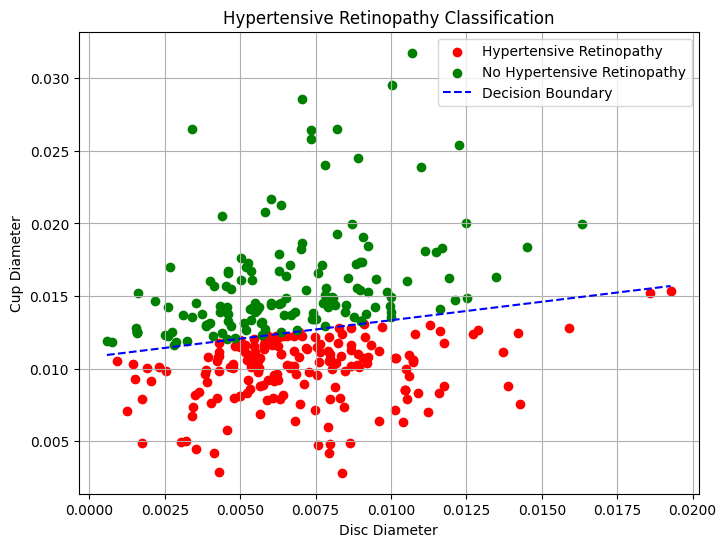

In [21]:
import matplotlib.pyplot as plt

colors = {"Hypertensive Retinopathy": "red", "No Hypertensive Retinopathy": "green", "Borderline/Unclear": "black"}

plt.figure(figsize=(8, 6))
for label in data["classification"].unique():
    subset = data[data["classification"] == label]
    plt.scatter(subset["disc_diameter"], subset["cup_diameter"], label=label, color=colors[label])

x_vals = np.linspace(data["disc_diameter"].min(), data["disc_diameter"].max(), 100)
y_vals = m * x_vals + c
plt.plot(x_vals, y_vals, '--', color='blue', label="Decision Boundary")

plt.xlabel("Disc Diameter")
plt.ylabel("Cup Diameter")
plt.title("Hypertensive Retinopathy Classification")
plt.legend()
plt.grid(True)
plt.show()


In [20]:
import pickle


with open("hypertensive_retinopathy_model.pkl", "wb") as f:
    pickle.dump({'slope': m, 'intercept': c}, f)
